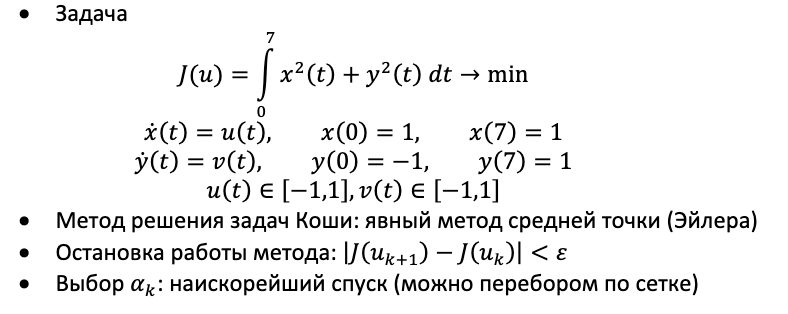

In [ ]:
import os
import sympy
from sympy import Symbol, diff
from sympy.parsing.sympy_parser import parse_expr
import scipy.integrate as integrate
import scipy
import imageio
import time
import numpy as np
from scipy.integrate import solve_ivp
from sympy import lambdify
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [ ]:
eps = 1e-1
alphas = np.linspace(0.001, 0.3, num=10)
t_space = np.linspace(0.0, 7.0, num=10000)
x0 = [1, -1]
xT = [1, 1]
tf = 7.0

In [ ]:
h = 7 / 1000
ts = np.arange(0.0 + h, tf + h, h)

def Euler(t0, x0, f):
    xs = []
    xs.append(x0)
    for i in range(len(t_space) - 1):
      xs.append(xs[i] + h * f(ts[i], xs[i]))
    return np.array(xs, dtype=float).T

In [ ]:
def bounds(val, a, b):
    if val < a:
        return a
    if val > b:
        return b
    return val


def projection(u,v):
    return np.array([[bounds(i, -1, 1) for i in u], [bounds(j, -1, 1) for j in v]])

In [ ]:
H = parse_expr("-x**2+psi*u", evaluate=True)
dHdx = diff(-H, Symbol("x"))
dHdx = lambdify(Symbol("x"), dHdx)

Fi = parse_expr("26 * (x_T - 0.5)**2")
dFidx = diff(Fi, Symbol("x_T"))
Fi = lambdify(Symbol('x_T'), Fi)

In [ ]:
def J(u):
      def fun(t, y):
          return np.array([u[0][np.argmin(np.abs(t_space - t))], u[1][np.argmin(np.abs(t_space - t))]])
      x = solve_ivp(fun, t_span=(0,tf), t_eval=t_space, y0=x0, dense_output=True)
      return integrate.simpson(x.y[0]**2, t_space) + integrate.simpson(x.y[1]**2, t_space) + Fi(x.sol(tf)[0]) + Fi(x.sol(tf)[1])

def psi(t, y):
      return np.array([dHdx(x(tf-t)[0]), dHdx(x(tf-t)[1])])

def dJdu():
      psi_T = np.array([dFidx.subs(Symbol("x_T"), x(tf)[0]), dFidx.subs(Symbol("x_T"), x(tf)[1])])
      sol = solve_ivp(psi, t_span=(0,tf), t_eval=t_space, y0=psi_T, dense_output=True)
      return np.array([sol.y[0][::-1], sol.y[1][::-1]])

def x_diff(t, y):
      return np.array([u_cur[0][np.argmin(np.abs(t_space - t))], u_cur[1][np.argmin(np.abs(t_space - t))]])

In [ ]:
u_cur = [np.full((len(t_space)), 1),  np.full((len(t_space)), 1)]
n_iter = 0
maxit = 10000
U = []
X = []
U.append(u_cur)
J_min = 123
u_min = [2, 2]
J_cur = J(u_cur)

U = []
X = []

In [ ]:
start_time = time.time()
J_val = 10000
while n_iter < maxit:
    x = solve_ivp(x_diff, t_span=(0,tf), t_eval=t_space, y0=x0, dense_output=True)
    x = x.sol
    J_cur = J(u_cur)
    J_dif = dJdu()
    n_iter += 1
    J_min = 100000
    J_old = J_cur

    for alpha in alphas:
        c = u_cur[0] - alpha * J_dif[0]      #Вычисляем значения u и v, берем проекцию, получаем новое управление
        m = u_cur[1] - alpha * J_dif[1]
        u_n = projection(c, m)
        J_val = J(u_n)   #вычисляем функционал
        if J_val < J_min:  # поиск наименьшего значения функционала по alpha
            u_cur = u_n
            J_min = J_val
    print(abs(J_old - J_val),'\t', n_iter)
    U.append(u_cur)
    X.append(x(t_space))
    if np.abs(J_old - J_val)<eps:      #Проверяем условие остановки метода

        break

728.0 	 1
2311.132507038881 	 2
2886.388792291342 	 3
3095.4527959451966 	 4
3171.4498449431735 	 5
3199.0987128632023 	 6
3209.174409211666 	 7
3212.873369118404 	 8
3035.8633748428397 	 9
2038.7748977798428 	 10
859.2030146257421 	 11
324.5188041657344 	 12
118.98908527264915 	 13
48.11293349364588 	 14
2487.8517209715515 	 15
2082.4188323535996 	 16
1074.9582080694202 	 17
465.7873586731941 	 18
185.7874433807157 	 19
68.53983062159416 	 20
36.25857550237493 	 21
2547.162691036727 	 22
1187.1722549285644 	 23
468.125866991901 	 24
174.1681983685791 	 25
62.3275478179266 	 26
23.641252528562934 	 27
9.760019247978999 	 28
1445.4741610618576 	 29
597.3935162577445 	 30
223.56489835038735 	 31
77.68598187128323 	 32
30.788119366988077 	 33
12.89667336489385 	 34
1420.0729643295338 	 35
551.357376828346 	 36
210.57239226256732 	 37
73.16189404902947 	 38
27.430881882615974 	 39
9.903501496054698 	 40
5.003451396826526 	 41
787.9069229643658 	 42
288.6622451457485 	 43
105.62785097725472

In [ ]:
fin_time = time.time() - start_time
print('fin_time = ', fin_time, '; J_min = ', J_min)

fin_time =  69.54895567893982 ; J_min =  0.8226519934868232


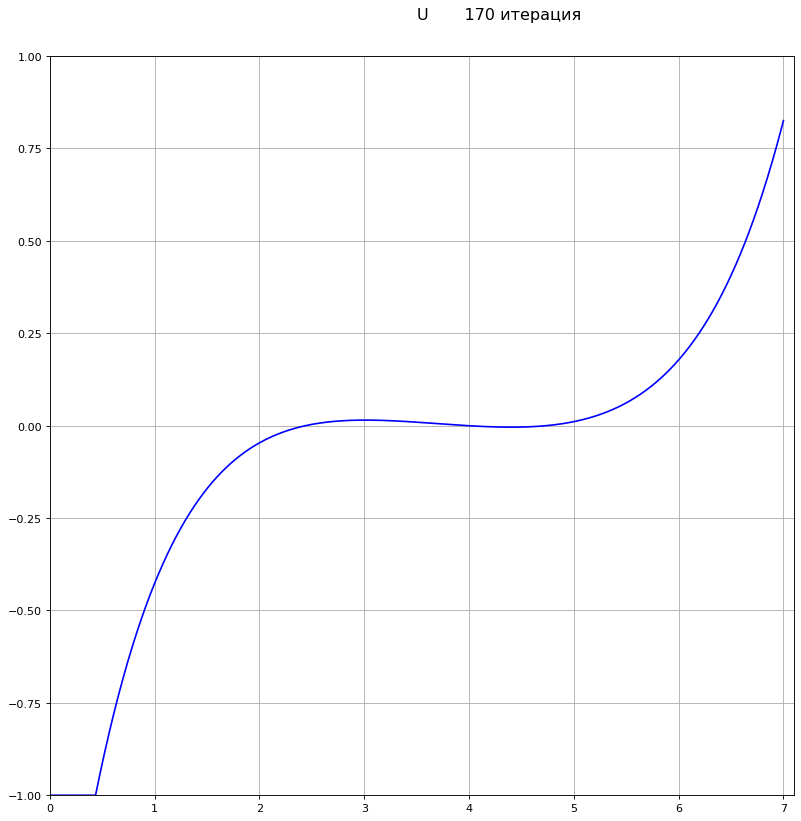

In [ ]:
U = np.array(U)

fig = plt.figure(figsize=(12,12), dpi=80)
ax = fig.add_subplot()
ax.grid()
ax.set_xlim([0, tf+0.1])
ax.set_ylim([-1, 1])

line, = ax.plot([], [], color='b')
text = ax.text(tf/2, 1.1, '', fontsize='x-large')

udata, tdata = [], []
tdata = t_space
def init():
    line.set_data([], [])
    return line,

def animate(i):
    udata = U[i][0]
    line.set_data(tdata, udata)
    text.set_text(f'U       {i+1} итерация')

    return line, text,

ani = animation.FuncAnimation(fig, animate, init_func=init, frames=U.shape[0], interval=100000, blit=True, repeat=False)
writer = animation.PillowWriter(fps=60)
ani.save(filename="u.gif",writer=writer)

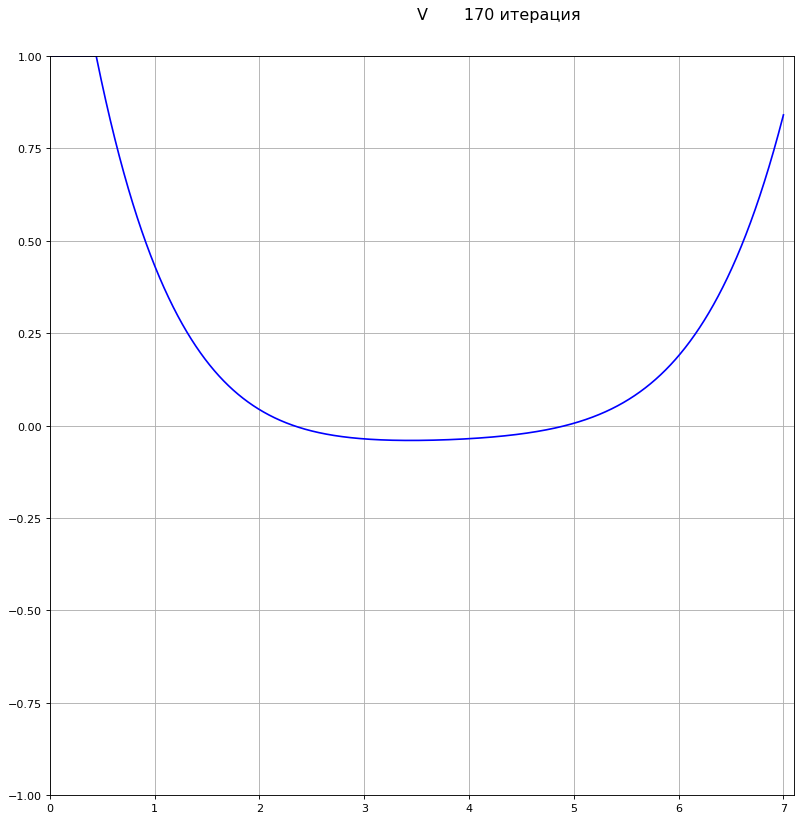

In [ ]:
fig = plt.figure(figsize=(12,12), dpi=80)
ax = fig.add_subplot()
ax.grid()
ax.set_xlim([0, tf+0.1])
ax.set_ylim([-1, 1])

line, = ax.plot([], [], color='b')
text = ax.text(tf/2, 1.1, '', fontsize='x-large')

udata, tdata = [], []
tdata = t_space
def init():
    line.set_data([], [])
    return line,

def animate(i):
    udata = U[i][1]
    line.set_data(tdata, udata)
    text.set_text(f'V       {i+1} итерация')

    return line, text,

ani = animation.FuncAnimation(fig, animate, init_func=init, frames=U.shape[0], interval=100000, blit=True, repeat=False)
writer = animation.PillowWriter(fps=60)
ani.save(filename="v.gif",writer=writer)

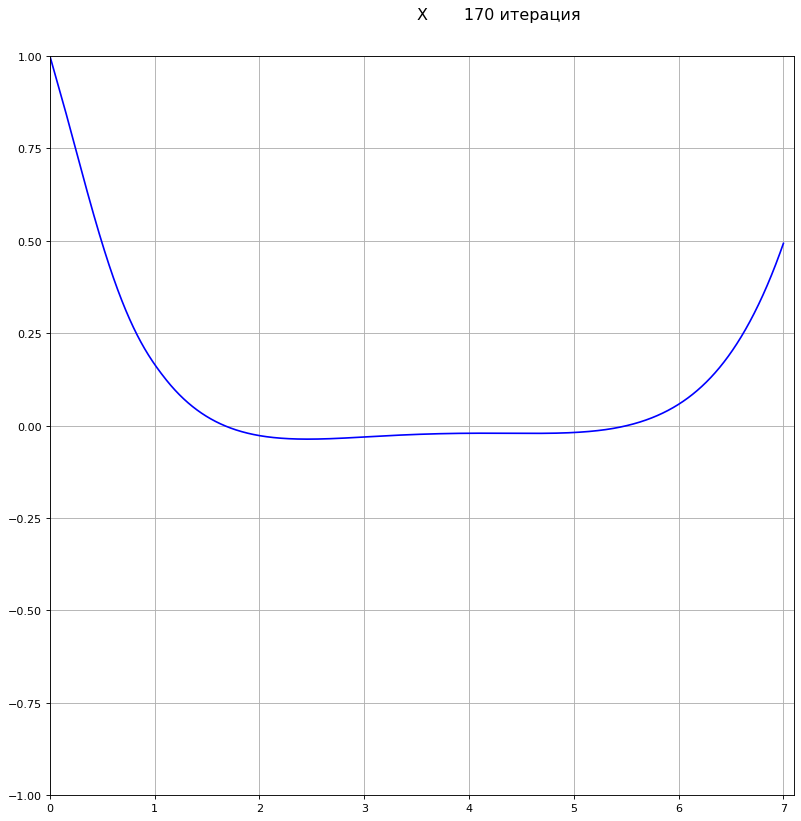

In [ ]:
X = np.array(X)

fig = plt.figure(figsize=(12,12), dpi=80)
ax = fig.add_subplot()
ax.grid()
ax.set_xlim([0, tf+0.1])
ax.set_ylim([-1, 1])

line, = ax.plot([], [], color='b')
text = ax.text(tf/2, 1.1, '', fontsize='x-large')

udata, tdata = [], []
tdata = t_space
def init():
    line.set_data([], [])
    return line,

def animate(i):
    udata = X[i][0]
    line.set_data(tdata, udata)
    text.set_text(f'X       {i+1} итерация')

    return line, text,

ani = animation.FuncAnimation(fig, animate, init_func=init, frames=U.shape[0], interval=100000, blit=True, repeat=False)
writer = animation.PillowWriter(fps=60)
ani.save(filename="x.gif",writer=writer)

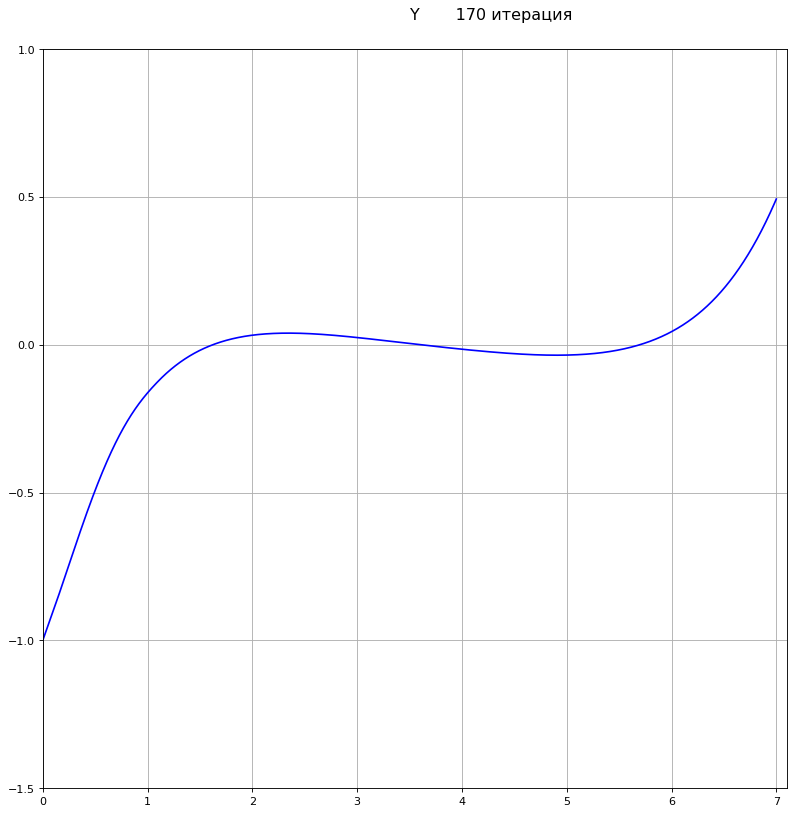

In [ ]:
fig = plt.figure(figsize=(12,12), dpi=80)
ax = fig.add_subplot()
ax.grid()
ax.set_xlim([0, tf+0.1])
ax.set_ylim([-1.5, 1])

line, = ax.plot([], [], color='b')
text = ax.text(tf/2, 1.1, '', fontsize='x-large')

udata, tdata = [], []
tdata = t_space
def init():
    line.set_data([], [])
    return line,

def animate(i):
    udata = X[i][1]
    line.set_data(tdata, udata)
    text.set_text(f'Y       {i+1} итерация')

    return line, text,

ani = animation.FuncAnimation(fig, animate, init_func=init, frames=X.shape[0], interval=100000, blit=True, repeat=False)
writer = animation.PillowWriter(fps=60)
ani.save(filename="y.gif",writer=writer)